In [1]:
import pandas as pd
import numpy as np
import math
#import matplotlib as plt
import matplotlib.pyplot as plt

def Y_a_b(genes, a, b):
    return np.mean(genes[a:b])

def C_a_b(genes, a, b):
    mean = Y_a_b(genes, a, b+1)
    return sum( (np.array(genes[a:b+1]) - mean) ** 2 )

def determine_h(P, i, j, genes):
  
  N = len(genes)
  
  if (i == 0 and j > 0):
    return Y_a_b(genes, P[i][j], P[i+1][j]) - Y_a_b(genes, 0, P[i][j]);
  elif (i == j and j > 0):
    return Y_a_b(genes, P[i][j], N) - Y_a_b(genes, P[i-1][j], P[i][j]);
  elif (i == 0 and j == 0):
    return Y_a_b(genes, P[i][j], N) - Y_a_b(genes, 0, P[i][j]);
  else:
    return Y_a_b(genes, P[i][j], P[i+1][j]) - Y_a_b(genes, P[i-1][j], P[i][j]);

def BASC_A(gene):
    gene_og = gene
    gene = np.sort(gene)
    N = len(gene)

    cost_matrix = [[0 for _ in range(N - 1)] for _ in range(N)]
    ind_matrix = [[0 for _ in range(N - 2)] for _ in range(N - 1)]
    P = [[0 for _ in range(N - 2)] for _ in range(N - 2)]

    # Step 1: Compute a Series of Step Function

    # initialization C_i_(0) = c_i_N
    # calculate first cost matrix column with no intermidiate break points
    for i in range(N):
        cost_matrix[i][0] = C_a_b(gene, i, N)

    # Algorithm 1: Calculate optimal step functions
    for j in range(N-2):
      
      for i in range(N-j-1):
        min_value = math.inf
        min_index = math.inf

        for d in range(N-j-1):
          
          if(i <= d):
            curr_value = C_a_b(gene, i, d) + cost_matrix[d+1][j]
          
          if(curr_value < min_value):
            min_value = curr_value
            min_index = d

        cost_matrix[i][j+1] = min_value
        ind_matrix[i][j] = min_index + 1

    #  Algorithm 2: Compute the break points of all optimal step functions
    for j in range(N-2):
      
      z = j
      
      P[0][j] = ind_matrix[0][z]
    
      if(j > 0):
        z = z - 1
        for i in range(1, j+1):
          
          P[i][j] = ind_matrix[P[i-1][j]][z]
          
          z = z - 1

    # Step 2: Find Strongest Discontinuity in Each Step Function
    v = [0] * (N-2)

    for j in range(N-2):
      
      max_value = -math.inf
      
      max_index = j
      
      for i in range(j+1):
        h = determine_h(P, i, j, gene)
        z = (gene[P[i][j]] + gene[P[i][j]-1]) / 2
        e = sum( (np.array(gene) - z) ** 2 )
        q_score = h / e
        if(q_score > max_value):
          
          max_value = q_score
          
          max_index = i

      
      v[j] = P[max_index][j]

    # Step 3: Estimate Location and Variation of the Strongest Discontinuities
    thr = (gene[round(np.median(v))-1] + gene[round(np.median(v))]) / 2

    return thr


In [2]:
from sklearn.cluster import KMeans

def K_Means(genes):
    data = np.array(genes).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, n_init='auto')
    kmeans.fit(data)
    c=kmeans.labels_
    genes = np.array(genes)
    groupOne = genes[c==1]
    groupZero = genes[c==0]
    
    thr1 = np.mean(groupOne)
    thr2 = np.mean(groupZero)
    
    thr = (thr1 + thr2) / 2

    return thr

In [3]:
def getSSTOT(x, n, xmean):
    m = 0
    for i in range(n):
        m = m + (x[i] - xmean)**2
    return m


def onestep(x):
    
    n = len(x)
    #step = 0
    xmean = np.mean(x)
    SSTOT = getSSTOT(x, n, xmean)
    
    SSEmin = SSTOT
    
    for i in range(n-1):
        leftMean = np.mean(x[0:i+1])
    
        rightMean = np.mean(x[i+1:n])
        
        SSE = 0
        
        for j in range(n):
            if j < i+1:
                SSE = SSE + (x[j] - leftMean)**2
            else:
                SSE = SSE + (x[j] - rightMean)**2
                    
        
        if SSEmin > SSE:
            SSEmin = SSE
            #print("1:",SSEmin1)
                
            t = (leftMean + rightMean)/2
    
    
    
    return t

In [4]:
def shmulevich(x):
    
    n = len(x)
    s = np.sort(x)
    d = np.empty(n)
    
    for i in range(n-2):
        d[i] = s[i+1] - s[i]
    
    t = (s[n-1] - s[0])/(n-1)
    
    mn = s[n-1]
    index = 0
    
    for i in range(n-1):
        if d[i] > t and d[i] < mn:
            mn = d[i]
            index = i
            
    z = s[index + 1]
   
    
    return z

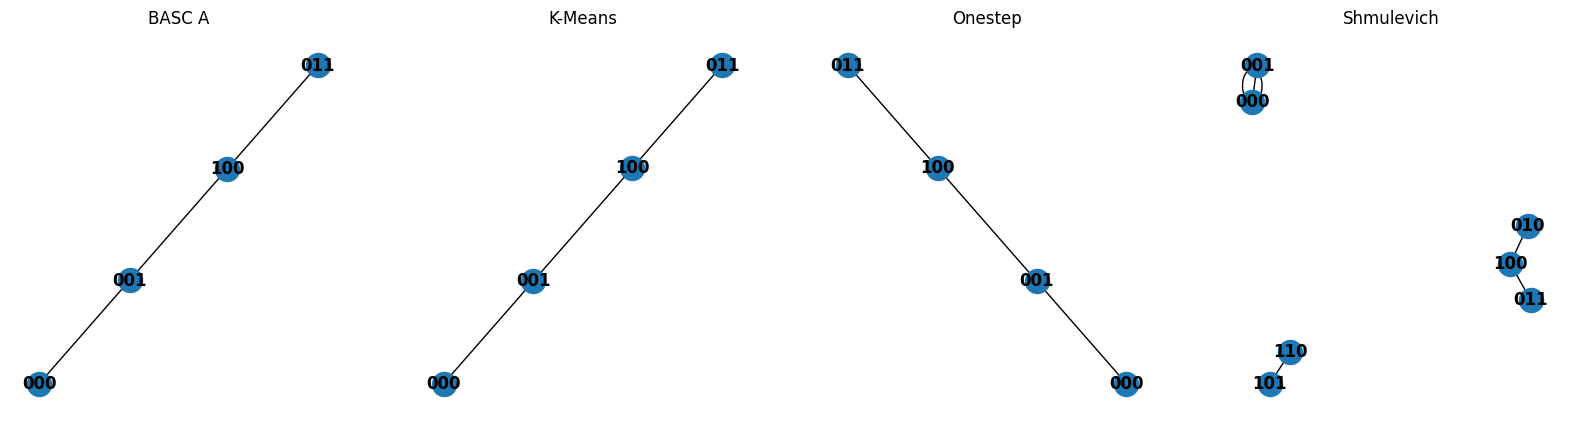

In [9]:
import networkx as nx

gene_data = pd.read_csv('tseriestest.txt', header=None)

def A(state):
    return state[1]

def B(state):
    return int(not state[0])

def C(state):
    return int(state[0] or state[1])

def generate_network(genes):
    
    binarize_arr = []
    
    binarized = []
    
    four_binary = []
    
    thr = []
    
    for i in genes:
            row = gene_data.iloc[i].values
            thr.append(BASC_A(row))
            thr.append(K_Means(row))
            thr.append(onestep(row))
            thr.append(shmulevich(row))
            
            for k in thr:
                for j in range(len(row)):
                    if(row[j] <= k):
                        binarized.append(0)
                    else:
                        binarized.append(1)
                binarize_arr.append(binarized)
                binarized = []
            four_binary.append(binarize_arr)
            binarize_arr = []
            thr = []
    
    #print(four_binary)
    
    label = []
    newlabel = []
    allStates = []
    
    m = len(four_binary)
    n = len(four_binary[0])
    l = len(four_binary[0][0])
    
    #print(m, n, l)
    
    #for binary in four_binary:
        #print(binary)
        
    #print("\n")
    
    for i in range(n):
            for x in range(l):
                for k in range(m):
                    label.append(four_binary[k][i][x])
                
                strBinary = str(''.join(map(str, label)))
                
                A_ = A(strBinary)
                B_ = B(strBinary)
                C_ = C(strBinary)
                
                newState = str(''.join(map(str, [A_, B_, C_])))
                
                #print(strBinary, "->", newState)
                newlabel.append({strBinary:newState})
                label = []
            allStates.append(newlabel)
            newlabel = []
            #print("")
            
    #print(allStates)
    #print("")
    
    differences = []

    for i in range(l):
        
        if len(set(tuple(lst[i].items()) for lst in allStates)) != 1:
            #print(f"Element {i + 1} is not the same in all lists:")
            #for j, lst in enumerate(allStates):
                #print(f"List {j + 1}: {lst[i]}", end=" ")
            differences.append(1)
                
        else:
            differences.append(0)
            
    #print(differences)
    
    G1 = nx.Graph()
    G2 = nx.Graph()
    G3 = nx.Graph()
    G4 = nx.Graph()
    
    for i in range(l):
        key = list(allStates[0][i].items())[0][0]
        value = list(allStates[0][i].items())[0][1]
        #print(key, value)
       
        G1.add_edge(key, value)
        
        key = list(allStates[1][i].items())[0][0]
        value = list(allStates[1][i].items())[0][1]
        #print(key, value)
       
        G2.add_edge(key, value)
        
        key = list(allStates[2][i].items())[0][0]
        value = list(allStates[2][i].items())[0][1]
        #print(key, value)
       
        G3.add_edge(key, value)
        
        key = list(allStates[3][i].items())[0][0]
        value = list(allStates[3][i].items())[0][1]
        #print(key, value)
       
        G4.add_edge(key, value)
         
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    pos1 = nx.spring_layout(G1)
    nx.draw(G1, with_labels=True, font_weight='bold', pos=pos1, ax=axs[0])
    axs[0].set_title('BASC A')

    pos2 = nx.spring_layout(G2)
    nx.draw(G2, with_labels=True, font_weight='bold', pos=pos2, ax=axs[1])
    axs[1].set_title('K-Means')

    pos3 = nx.spring_layout(G3)
    nx.draw(G3, with_labels=True, font_weight='bold', pos=pos3, ax=axs[2])
    axs[2].set_title('Onestep')

    pos4 = nx.spring_layout(G4)
    nx.draw(G4, with_labels=True, font_weight='bold', pos=pos4, ax=axs[3])
    axs[3].set_title('Shmulevich')

    plt.show()

    #selected = {'A': 1, 'B': 5, 'C': 9}
selected = [1, 4, 5]

generate_network(selected)

# erizos

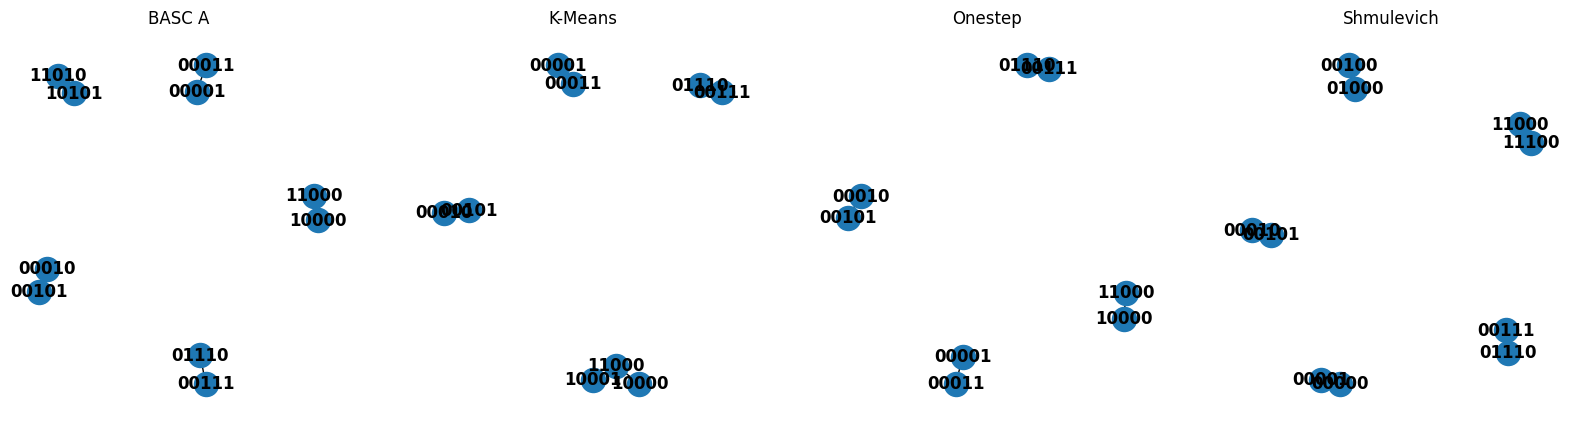

In [6]:
import networkx as nx

gene_data = pd.read_csv('tseriestest.txt', header=None)

def A(state):
    return state[0]

def B(state):
    return int(state[0] or state[2])

def C(state):
    return int(state[1])

def D(state):
    return int(state[2])

def F(state):
    return int(state[3])

def generate_network(genes):
    
    binarize_arr = []
    
    binarized = []
    
    four_binary = []
    
    thr = []
    
    for i in genes:
            row = gene_data.iloc[i].values
            thr.append(BASC_A(row))
            thr.append(K_Means(row))
            thr.append(onestep(row))
            thr.append(shmulevich(row))
            
            for k in thr:
                for j in range(len(row)):
                    if(row[j] <= k):
                        binarized.append(0)
                    else:
                        binarized.append(1)
                binarize_arr.append(binarized)
                binarized = []
            four_binary.append(binarize_arr)
            binarize_arr = []
            thr = []
    
    #print(four_binary)
    
    label = []
    newlabel = []
    allStates = []
    
    m = len(four_binary)
    n = len(four_binary[0])
    l = len(four_binary[0][0])
    
    #print(m, n, l)
    
    #for binary in four_binary:
        #print(binary)
        
    #print("\n")
    
    for i in range(n):
            for x in range(l):
                for k in range(m):
                    label.append(four_binary[k][i][x])
                
                strBinary = str(''.join(map(str, label)))
                
                A_ = A(strBinary)
                B_ = B(strBinary)
                C_ = C(strBinary)
                D_ = D(strBinary)
                F_ = F(strBinary)
                
                newState = str(''.join(map(str, [A_, B_, C_, D_, F_])))
                
                #print(strBinary, "->", newState)
                newlabel.append({strBinary:newState})
                label = []
            allStates.append(newlabel)
            newlabel = []
            #print("")
            
    #print(allStates)
    #print("")
    
    differences = []

    for i in range(l):
        
        if len(set(tuple(lst[i].items()) for lst in allStates)) != 1:
            #print(f"Element {i + 1} is not the same in all lists:")
            #for j, lst in enumerate(allStates):
                #print(f"List {j + 1}: {lst[i]}", end=" ")
            differences.append(1)
                
        else:
            differences.append(0)
            
    #print(differences)
    
    G1 = nx.Graph()
    G2 = nx.Graph()
    G3 = nx.Graph()
    G4 = nx.Graph()
    
    for i in range(l):
        key = list(allStates[0][i].items())[0][0]
        value = list(allStates[0][i].items())[0][1]
        #print(key, value)
       
        G1.add_edge(key, value)
        
        key = list(allStates[1][i].items())[0][0]
        value = list(allStates[1][i].items())[0][1]
        #print(key, value)
       
        G2.add_edge(key, value)
        
        key = list(allStates[2][i].items())[0][0]
        value = list(allStates[2][i].items())[0][1]
        #print(key, value)
       
        G3.add_edge(key, value)
        
        key = list(allStates[3][i].items())[0][0]
        value = list(allStates[3][i].items())[0][1]
        #print(key, value)
       
        G4.add_edge(key, value)
         
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    pos1 = nx.spring_layout(G1)
    nx.draw(G1, with_labels=True, font_weight='bold', pos=pos1, ax=axs[0])
    axs[0].set_title('BASC A')

    pos2 = nx.spring_layout(G2)
    nx.draw(G2, with_labels=True, font_weight='bold', pos=pos2, ax=axs[1])
    axs[1].set_title('K-Means')

    pos3 = nx.spring_layout(G3)
    nx.draw(G3, with_labels=True, font_weight='bold', pos=pos3, ax=axs[2])
    axs[2].set_title('Onestep')

    pos4 = nx.spring_layout(G4)
    nx.draw(G4, with_labels=True, font_weight='bold', pos=pos4, ax=axs[3])
    axs[3].set_title('Shmulevich')

    plt.show()

    #selected = {'A': 1, 'B': 5, 'C': 9}
selected = [1, 4, 3, 8, 2]

generate_network(selected)